# Chapter 4. Generalizing Linear Models

In [22]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap
from jax import nn as jnn

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [9]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# import theano.tensor as tt
# import seaborn as sns
# import scipy.stats as stats
# from scipy.special import expit as logistic
# import matplotlib.pyplot as plt
# import arviz as az

In [10]:
# az.style.use('arviz-darkgrid')

## Logistic regression

Text(0, 0.5, 'logistic(z)')

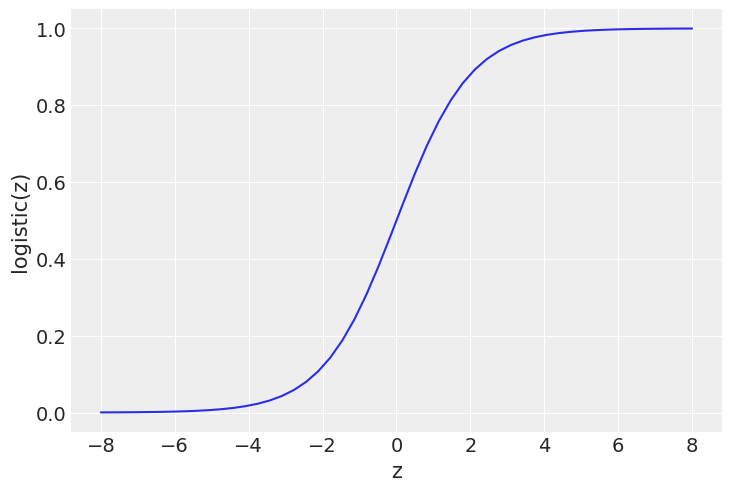

In [11]:
z = jnp.linspace(-8, 8)
plt.plot(z, 1 / (1 + jnp.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

## The iris dataset

In [12]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<AxesSubplot:xlabel='species', ylabel='sepal_length'>

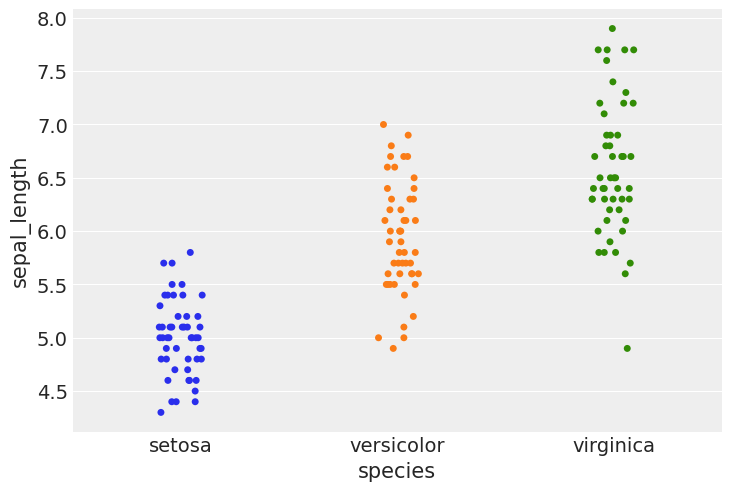

In [13]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

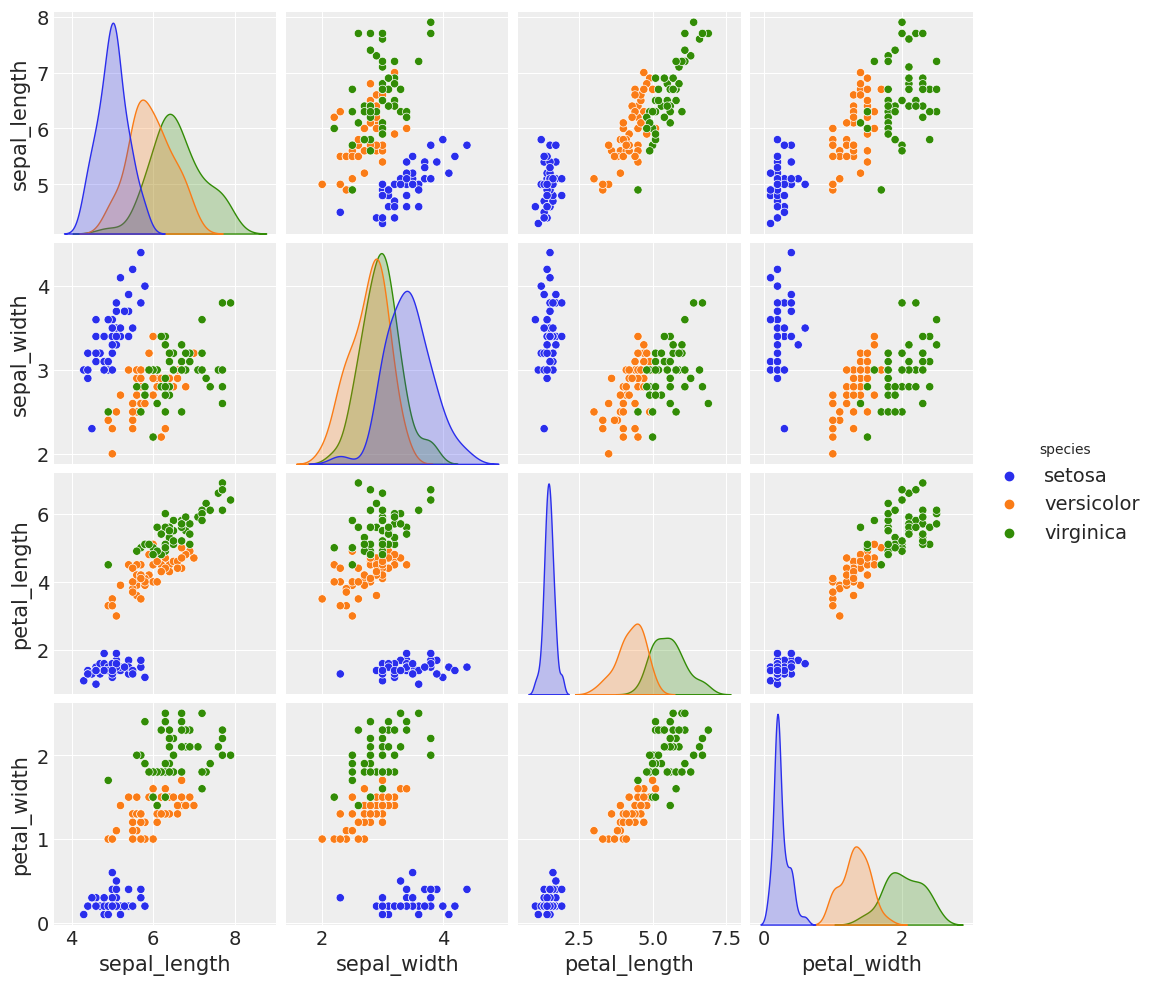

In [19]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### The logistic model applied to the iris dataset

In [20]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [29]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + jnp.dot(x_c, β)
    θ = numpyro.deterministic('θ', jnn.sigmoid(μ))
    bd = numpyro.deterministic('bd', -α/β)
    
    yl = numpyro.sample('yl', dist.Bernoulli(probs=θ), obs=obs)
    
    
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(seed), obs=y_0)

sample: 100%|████████████████████████| 10000/10000 [00:01<00:00, 6647.43it/s, 3 steps of size 6.80e-01. acc. prob=0.91]


In [30]:
varnames = ['α', 'β', 'bd']
az.summary(mcmc, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.134,0.273,-0.395,0.631,0.002,0.002,16846.0,14060.0,1.0
β,3.255,0.542,2.237,4.254,0.004,0.003,16426.0,13782.0,1.0
bd,-0.040,0.085,-0.204,0.116,0.001,0.001,17877.0,14539.0,1.0


In [32]:
# az.plot_trace(mcmc, compact=False)

In [52]:
jnp.squeeze(dist.Normal(y_0, 0.02).sample(random.PRNGKey(0), (1,)), axis=0).shape, x_c.shape

((100,), (100,))

([<matplotlib.axis.XTick at 0x1376ac670>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

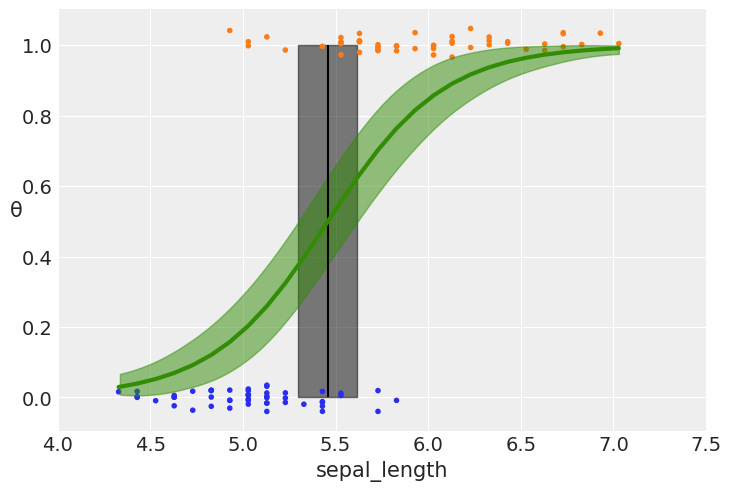

In [54]:
theta = mcmc.get_samples()['θ'].mean(axis=0)
idx = jnp.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)

plt.vlines(mcmc.get_samples()['bd'].mean(), 0, 1, color='k')

bd_hdi = az.hdi(mcmc.get_samples()['bd'].copy())
plt.fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='k', alpha=0.5)

plt.scatter(x_c, jnp.squeeze(dist.Normal(y_0, 0.02).sample(random.PRNGKey(0), (1,)), axis=0),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hdi(x_c, mcmc.get_samples()['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, jnp.round(locs + x_0.mean(), 1))

# Multiple logistic regression

In [11]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [12]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 432.81draws/s]


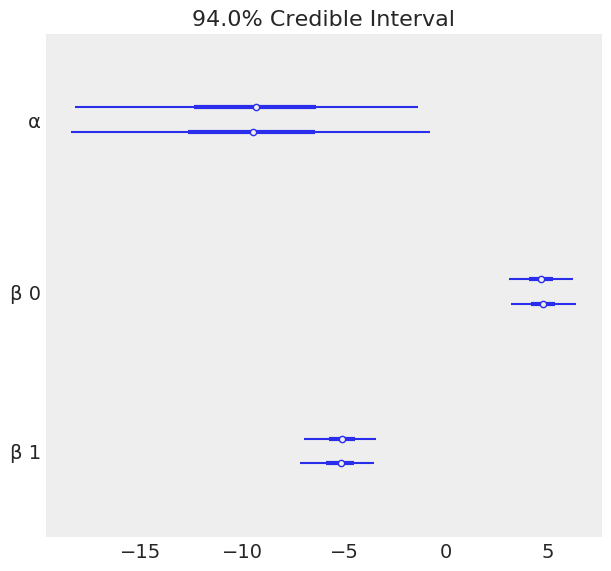

In [13]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

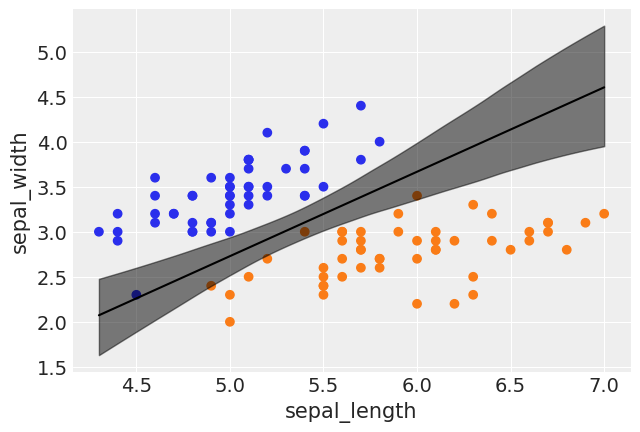

In [14]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1['bd'].mean(0)[idx] 
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0]) 
plt.plot(x_1[:,0][idx], bd, color='k'); 

az.plot_hpd(x_1[:,0], trace_1['bd'], color='k')
 
plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])
plt.savefig('B11197_04_05.png', dpi=300);

## Interpreting the coefficients of a logistic regression

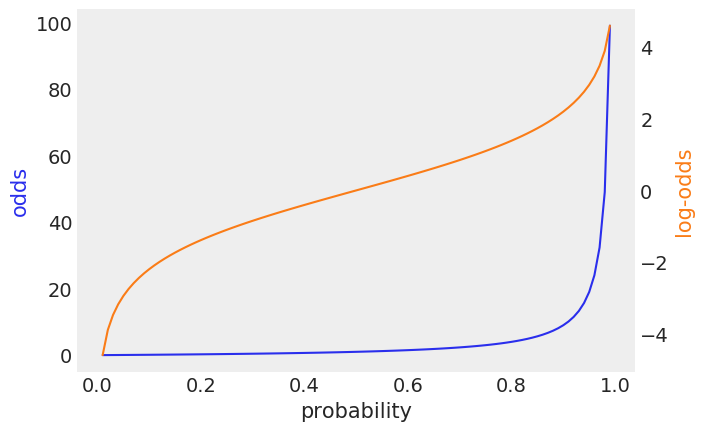

In [15]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)
plt.savefig('B11197_04_06.png', dpi=300);

In [16]:
df = az.summary(trace_1, var_names=varnames)
df

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-9.50,4.65,0.11,-18.38,-1.09,1276.0,1.0
β[0],4.74,0.87,0.03,3.18,6.39,1339.0,1.0
β[1],-5.18,0.97,0.02,-7.09,-3.50,1679.0,1.0


In [17]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)


log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(4.739999999999998, 0.7130232064228376)

## Dealing with correlated variables

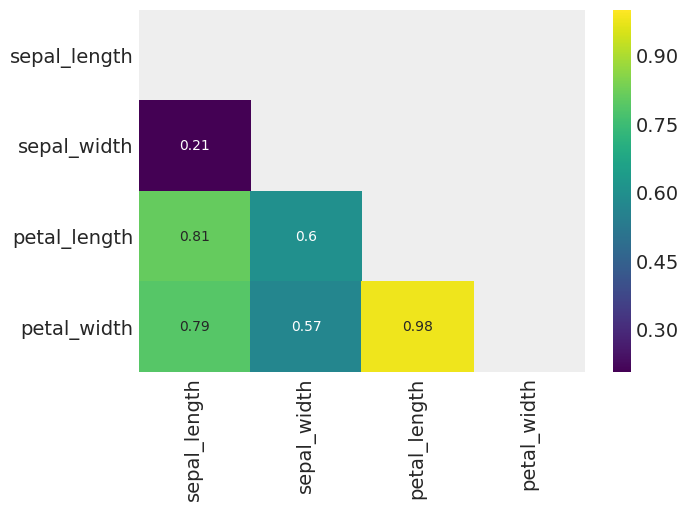

In [18]:
corr = iris[iris['species'] != 'virginica'].corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')
plt.savefig('B11197_04_07.png', dpi=300, bbox_inches='tight');

## Dealing with unbalanced classes

In [19]:
df = iris.query("species == ('setosa', 'versicolor')") 
df = df[45:]  
y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

In [20]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 455.34draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
#az.plot_trace(trace_3, varnames);

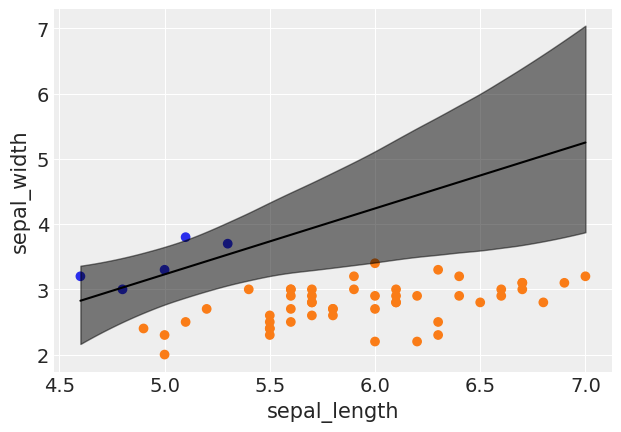

In [22]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx] 
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hpd(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

plt.savefig('B11197_04_08.png', dpi=300);

## Softmax regression

In [23]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [24]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:28<00:00, 177.90draws/s]


In [25]:
#az.plot_forest(trace_s, var_names=['α', 'β']);

In [26]:
data_pred = trace_s['μ'].mean(0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

'0.98'

In [27]:
with pm.Model() as model_sf:
    α = pm.Normal('α', mu=0, sd=2, shape=2)
    β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
    α_f = tt.concatenate([[0] ,α])
    β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_sf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 368.28draws/s]


## Discriminative and generative models

In [28]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,
                           observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1839.15draws/s]
The acceptance probability does not match the target. It is 0.8802638398814067, but should be close to 0.8. Try to increase the number of tuning steps.


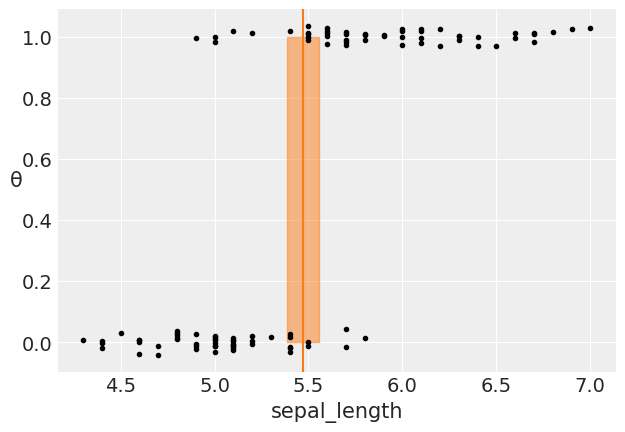

In [29]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png', dpi=300)

In [30]:
az.summary(trace_lda)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ[0],5.01,0.07,0.0,4.90,5.15,2074.0,1.0
μ[1],5.94,0.06,0.0,5.81,6.05,2458.0,1.0
σ,0.45,0.03,0.0,0.39,0.51,2404.0,1.0
bd,5.47,0.05,0.0,5.38,5.56,2327.0,1.0


### The Poisson distribution

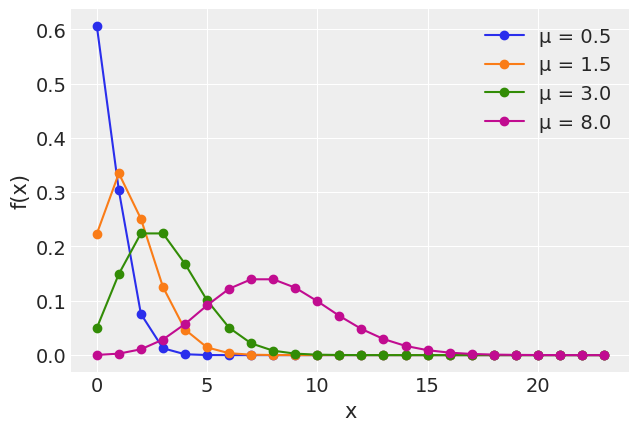

In [31]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('B11197_04_10.png', dpi=300);

## The Zero-Inflated Poisson model

In [32]:
n = 100
θ_real = 2.5
ψ = 0.1

# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])

In [33]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 2, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ,
                               observed=counts)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2620.41draws/s]


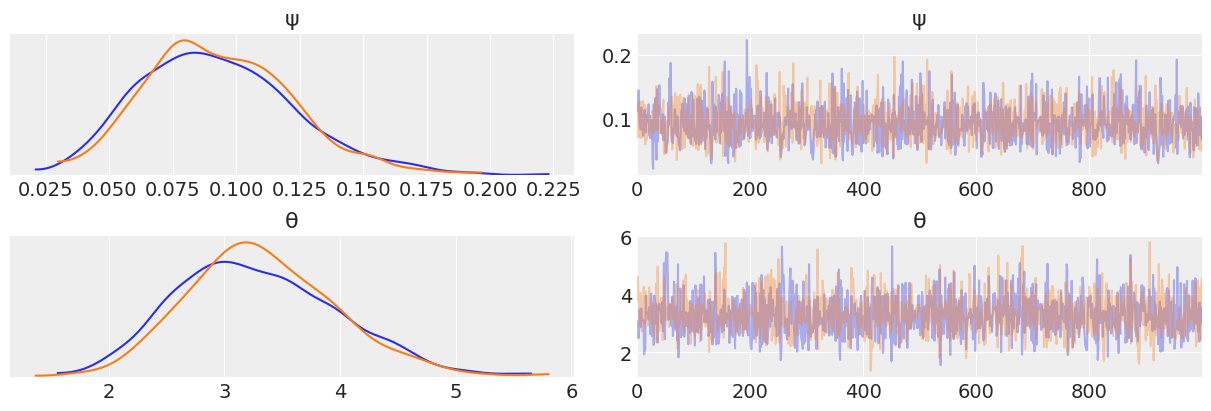

In [34]:
az.plot_trace(trace)
plt.savefig('B11197_04_11.png', dpi=300);

In [35]:
#az.summary(trace)

## Poisson regression and ZIP regression

In [36]:
fish_data = pd.read_csv('../data/fish.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, ψ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 741.29draws/s]


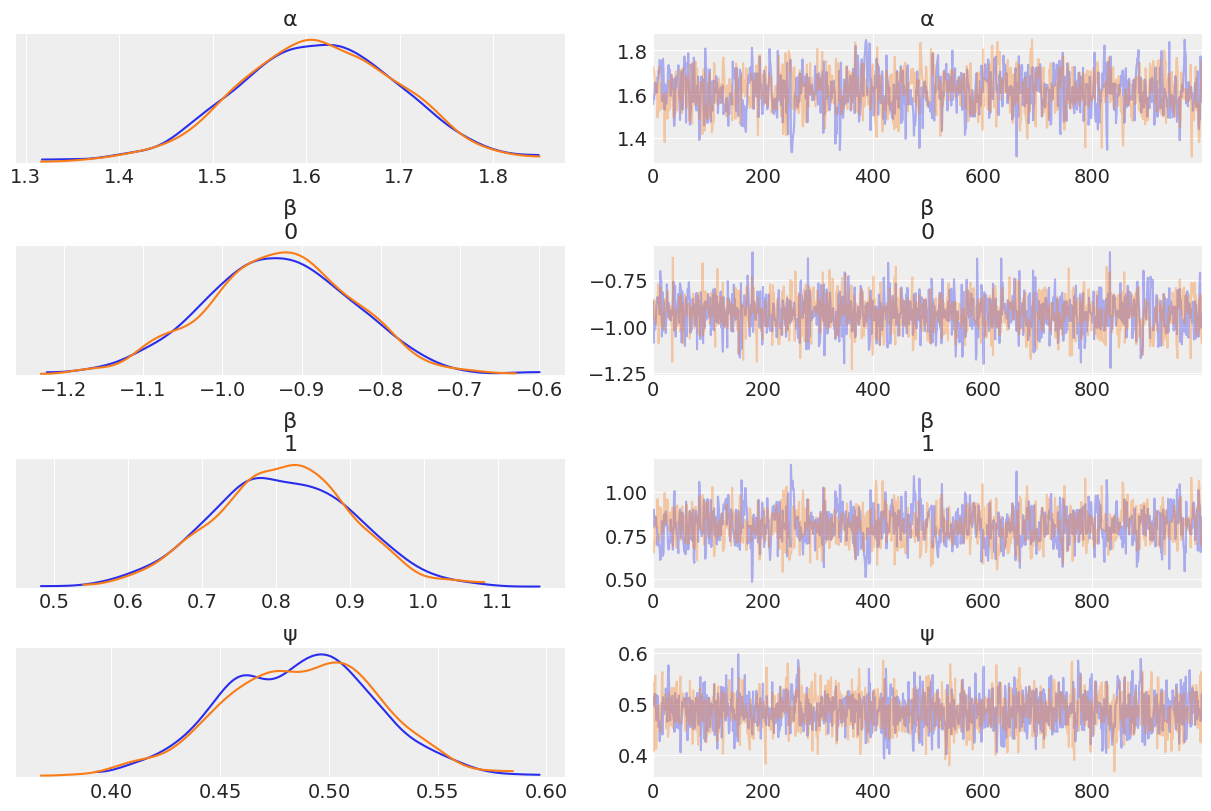

In [37]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(1000)
az.plot_trace(trace_ZIP_reg);

In [38]:
az.summary(trace_ZIP_reg)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,1.61,0.09,0.0,1.46,1.78,938.0,1.0
β[0],-0.93,0.09,0.0,-1.10,-0.76,1605.0,1.0
β[1],0.81,0.10,0.0,0.63,0.98,953.0,1.0
ψ,0.49,0.04,0.0,0.42,0.56,1695.0,1.0


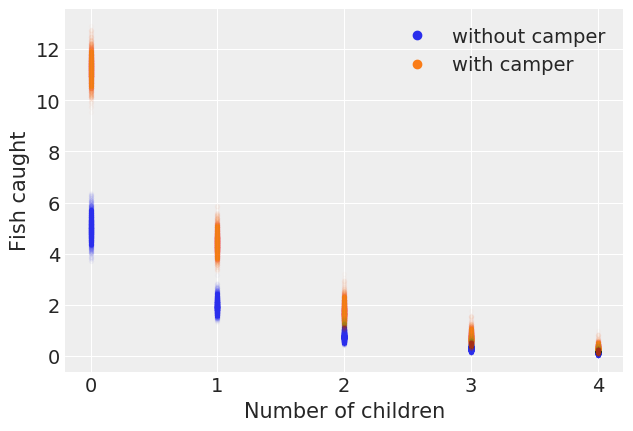

In [39]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png', dpi=300);

## Robust logistic regression

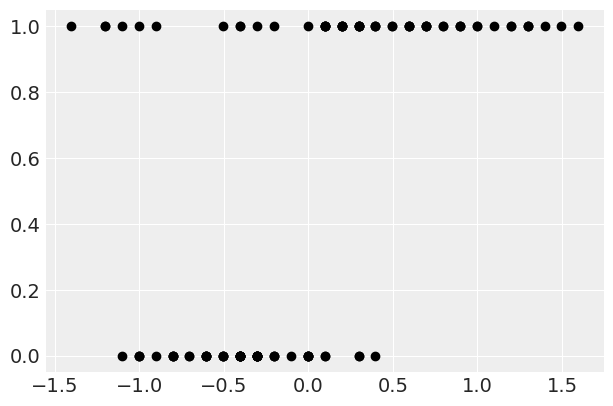

In [40]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 
plt.plot(x_c, y_0, 'o', color='k');

In [41]:
with pm.Model() as model_rlg:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + x_c *  β  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    
    π = pm.Beta('π', 1., 1.) 
    p = π * 0.5 + (1 - π) * θ 
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1794.94draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


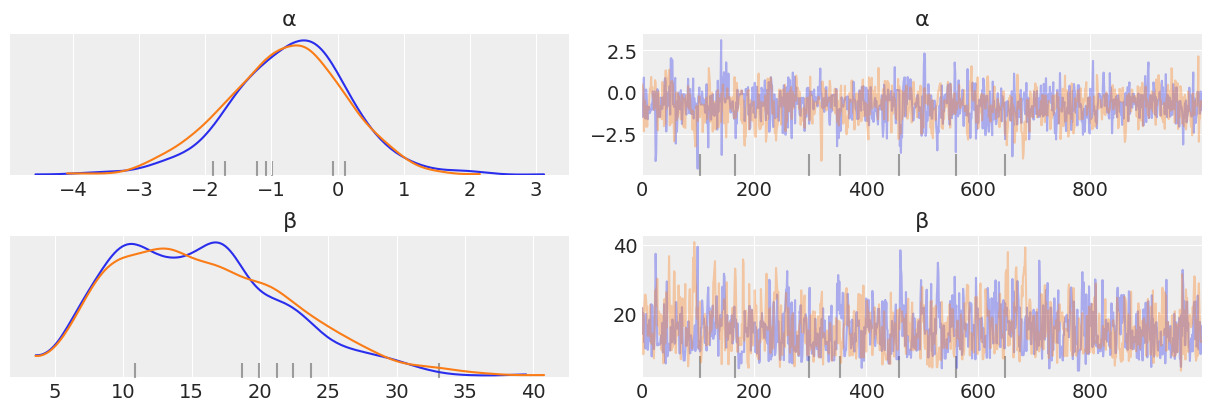

In [42]:
az.plot_trace(trace_rlg, varnames);

In [43]:
varnames = ['α', 'β', 'bd']
az.summary(trace_rlg, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-0.78,0.90,0.04,-2.46,0.94,980.0,1.0
β,15.77,6.36,0.26,5.65,27.70,821.0,1.0
bd,0.05,0.06,0.00,-0.05,0.17,1191.0,1.0


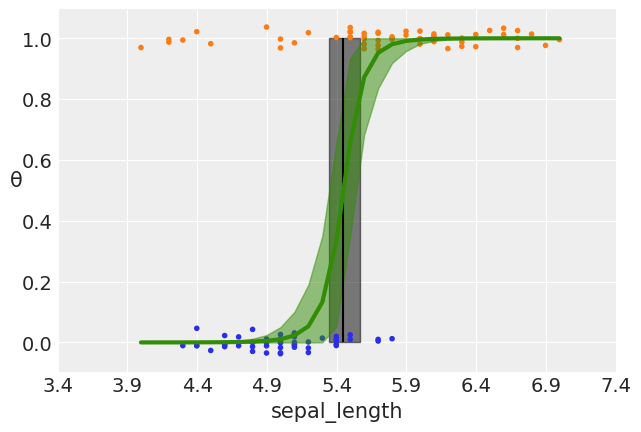

In [44]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3);
plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
theta_hpd = az.hpd(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_13.png', dpi=300);